In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# 定义计算设备和超参数

In [4]:
# 定义计算设备
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 定义超参数
learning_rate=0.001
num_classes=10
batch_size=64
num_epochs=20

# 准备MNIST数据集

In [4]:
# 注意root参数表示存在MNIST/processed/training.pt和MNIST/processed/test.pt的子目录的根目录
# 训练数据集
train_dataset=MNIST(root="/dataset/train/",
                   train=True,
                   transform=transforms.Compose([
                       transforms.Resize(size=(28,28)),
                       transforms.ToTensor()
                   ]))
# 测试数据集
test_dataset=MNIST(root="/dataset/train",
                   train=False,
                   transform=transforms.Compose([
                       transforms.Resize(size=(28,28)),
                       transforms.ToTensor()
                   ]))

In [5]:
# 数据探索
train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print("The size of train/test dataset is {}/{}.".format(train_dataset_size,test_dataset_size))

The size of train/test dataset is 60000/10000.


# 定义DataLoader

In [6]:
# 定义数据集加载器
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=True)

In [7]:
print(len(train_loader),len(test_loader))

938 157


In [8]:
print(len(train_dataset)//batch_size,len(test_dataset)//batch_size)

937 156


In [9]:
# 查看第一次采样结果
train_loader.__iter__().next()

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [10]:
images,labels=next(iter(train_loader))

In [11]:
images.shape

torch.Size([64, 1, 28, 28])

In [12]:
labels.shape

torch.Size([64])

# 显示部分手写体数字图片

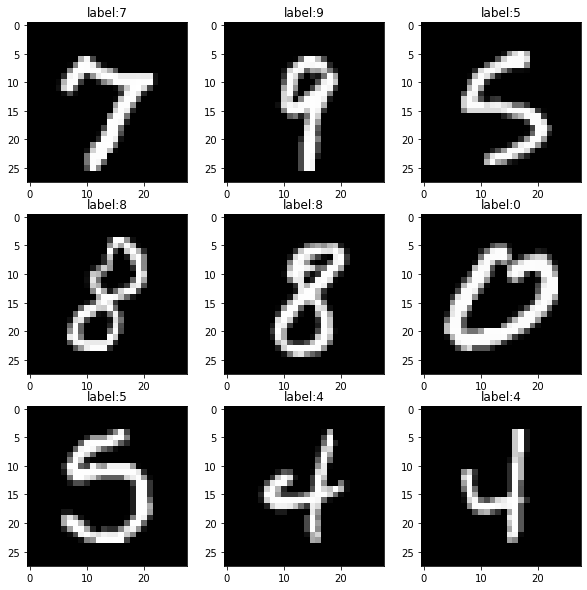

In [13]:
# 显示9张手写数字图片
plt.figure(figsize=(10,10))
index=0
for img,target in zip(images[:9],labels[:9]):
    index+=1
    plt.subplot(3,3,index)
    plt.title("label:{}".format(target))
    plt.imshow(img.permute(1,2,0),cmap="gray")

In [14]:
images[0].numel()

784

# 将数据集参数提取为C/C++头文件

In [15]:
# 将手写体图像转换为一维数组存储在.h文件中
for im,lab in zip(images,labels):
    length=im.numel()
    im=str(im.tolist())
    im=im.replace("[","")
    im=im.replace("]","")
    with open("input_{}.h".format(lab),"w") as fw:
        fw.write("double input_{}[{}] = {{{}}};\n".format(lab,length,im))# 三个嵌套大括号表示输出一个大括号

# 定义两层的神经网络

In [2]:
class TwoLayer(nn.Module):
    def __init__(self,num_classes):
        super(TwoLayer,self).__init__()
        self.num_classes=num_classes
        self.fc1=nn.Linear(784,64)
        self.fc2=nn.Linear(64,num_classes)
        self.elu=nn.ELU()
    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        x=self.elu(x)
        x=self.fc2(x)
        return x

In [17]:
model=TwoLayer(num_classes)

In [18]:
model=model.to(device)

# 查看模型结构和参数

In [19]:
model

TwoLayer(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (elu): ELU(alpha=1.0)
)

In [20]:
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
               ELU-2                   [-1, 64]               0
            Linear-3                   [-1, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


# 训练模型

In [21]:
# 定义损失函数
loss_function=nn.CrossEntropyLoss()
# 定义优化器
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
# 事件写入对象
writer = SummaryWriter(log_dir="model_logs")

In [23]:
# 开始训练
for epoch in range(num_epochs):
    print("第{}轮训练开始....".format(epoch + 1))
    total_train_acc = 0
    total_test_acc = 0
    # 训练步骤开始
    model.train()
    for imgs,targets in train_loader:
        # 将训练数据样本及其标签迁移到运算设备
        imgs=imgs.to(device)
        targets=targets.to(device)
        # 将神经网络全部参数梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs=model(imgs)
        total_train_acc += (outputs.argmax(dim=1) == targets).sum().item()
        loss=loss_function(outputs,targets)
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
    # 测试步骤开始
    model.eval()
    with torch.no_grad():
        for imgs,targets in test_loader:
            # 将测试数据样本及其标签迁移到运算设备
            imgs=imgs.to(device)
            targets=targets.to(device)  
            outputs=model(imgs)
            total_test_acc += (outputs.argmax(dim=1) == targets).sum().item()
    writer.add_scalars("ACC",{"train acc":total_train_acc/train_dataset_size,
                              "test acc":total_test_acc / test_dataset_size},epoch+1)
    torch.save(model.state_dict(), "models/model_epoch{}.pth".format(epoch + 1))
    print("模型保存成功！")

第1轮训练开始....
模型保存成功！
第2轮训练开始....
模型保存成功！
第3轮训练开始....
模型保存成功！
第4轮训练开始....
模型保存成功！
第5轮训练开始....
模型保存成功！
第6轮训练开始....
模型保存成功！
第7轮训练开始....
模型保存成功！
第8轮训练开始....
模型保存成功！
第9轮训练开始....
模型保存成功！
第10轮训练开始....
模型保存成功！
第11轮训练开始....
模型保存成功！
第12轮训练开始....
模型保存成功！
第13轮训练开始....
模型保存成功！
第14轮训练开始....
模型保存成功！
第15轮训练开始....
模型保存成功！
第16轮训练开始....
模型保存成功！
第17轮训练开始....
模型保存成功！
第18轮训练开始....
模型保存成功！
第19轮训练开始....
模型保存成功！
第20轮训练开始....
模型保存成功！


In [26]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
logs_dir = 'model_logs/'
%tensorboard --logdir logs_dir

In [25]:
# 关闭事件写入对象
writer.close()

# 模型验证

In [7]:
# 创建一个神经网络实例并迁移到device上面
best_model=TwoLayer(num_classes)
best_model=best_model.to(device)

In [8]:
# 将第15轮训练好的参数加载到神经网络中
best_model.load_state_dict(torch.load("models/model_epoch15.pth"))

<All keys matched successfully>

In [9]:
# 查看神经网络结构
best_model

TwoLayer(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (elu): ELU(alpha=1.0)
)

In [13]:
# 查看神经网络参数和值的键值对
best_model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0178,  0.0287, -0.0187,  ...,  0.0194, -0.0052, -0.0057],
                      [-0.0235, -0.0194,  0.0319,  ...,  0.0261,  0.0152, -0.0233],
                      [-0.0305,  0.0227, -0.0342,  ...,  0.0221, -0.0182,  0.0337],
                      ...,
                      [ 0.0119,  0.0035, -0.0068,  ...,  0.0071,  0.0264,  0.0188],
                      [ 0.0082, -0.0258, -0.0171,  ...,  0.0027,  0.0207, -0.0112],
                      [-0.0096,  0.0233,  0.0208,  ...,  0.0128,  0.0138, -0.0294]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([ 0.0645,  0.0657, -0.4509,  0.0308, -0.1290, -0.1913,  0.1621,  0.2732,
                       0.0875, -0.3909,  0.0919, -0.1450, -0.1341,  0.0322, -0.1189, -0.0927,
                      -0.1239,  0.1298,  0.3445,  0.1973, -0.2774, -0.1639,  0.3863, -0.0664,
                       0.2876,  0.2047, -0.3421,  0.4779, -0.0565,  0.0490,  0.3046, -0.2873

In [14]:
# 将存储参数和值的键值对的有序字典转换为哈希表
name_value_dict=dict(best_model.state_dict())

In [16]:
# 查看第一个全连接层权重张量的维度
name_value_dict['fc1.weight'].shape 

torch.Size([64, 784])

In [17]:
# 获得第一个全连接层权重张量的元素数量
name_value_dict['fc1.weight'].numel()

50176

# 将模型参数提取为C/C++头文件

In [31]:
for key in name_value_dict:
    length=name_value_dict[key].numel() # 获得每一个张量的元素数量作为数组大小
    flattened_tensor=name_value_dict[key].flatten().tolist() #将高维张量类型数据展平为一维列表数据
    key=key.replace(".","_")
    with open(key+".h","w") as fw:
        fw.write("double {}[{}] = {{{}}};\n".format(key,length,str(flattened_tensor).strip("[]")))

In [19]:
name_value_dict['fc1.weight']

tensor([[ 0.0178,  0.0287, -0.0187,  ...,  0.0194, -0.0052, -0.0057],
        [-0.0235, -0.0194,  0.0319,  ...,  0.0261,  0.0152, -0.0233],
        [-0.0305,  0.0227, -0.0342,  ...,  0.0221, -0.0182,  0.0337],
        ...,
        [ 0.0119,  0.0035, -0.0068,  ...,  0.0071,  0.0264,  0.0188],
        [ 0.0082, -0.0258, -0.0171,  ...,  0.0027,  0.0207, -0.0112],
        [-0.0096,  0.0233,  0.0208,  ...,  0.0128,  0.0138, -0.0294]],
       device='cuda:0')